In [1]:
import os
import json
from pprint import pprint


In [2]:
data = json.load(open('data/tiny-dev.json'))

pprint(data)

{u'data': [{u'paragraphs': [{u'context': u'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24\u201310 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.',
                             u'qas': [{u'answers': [{u'answer_start': 177,
                                                     u'text': u'Denver Broncos'},
                

                                      {u'answers': [{u'answer_start': 892,
                                                     u'text': u'eight'},
                                                    {u'answer_start': 892,
                                                     u'text': u'eight'},
                                                    {u'answer_start': 892,
                                                     u'text': u'eight'}],
                                       u'id': u'56beb3083aeaaa14008c9240',
                                       u'question': u'How many Panthers were designated All-Pro?'},
                                      {u'answers': [{u'answer_start': 85,
                                                     u'text': u'Kelvin Benjamin'},
                                                    {u'answer_start': 85,
                                                     u'text': u'Kelvin Benjamin'},
                                                    {u'answer_star

                                                     u'text': u'city council'}],
                                       u'id': u'56bf555e3aeaaa14008c95d5',
                                       u'question': u'Which government entity helped to pay for the festivities, beyond businesses and individuals?'},
                                      {u'answers': [{u'answer_start': 167,
                                                     u'text': u'Bellomy Field'},
                                                    {u'answer_start': 167,
                                                     u'text': u'Bellomy Field'},
                                                    {u'answer_start': 102,
                                                     u'text': u'Santa Clara Convention Center'}],
                                       u'id': u'56d714cd0d65d21400198356',
                                       u'question': u'Where was a beer, wine and food festival held at prior to the Super Bowl?'},
  

                                      {u'answers': [{u'answer_start': 832,
                                                     u'text': u'Trevathan'},
                                                    {u'answer_start': 832,
                                                     u'text': u'Trevathan'},
                                                    {u'answer_start': 832,
                                                     u'text': u'Trevathan'}],
                                       u'id': u'56d7282f0d65d2140019840c',
                                       u'question': u"Who recovered Ward's fumble?"},
                                      {u'answers': [{u'answer_start': 118,
                                                     u'text': u'Ted Ginn Jr.'},
                                                    {u'answer_start': 118,
                                                     u'text': u'Ted Ginn Jr'}],
                                       u'id': u'56d9c92bdc89441400fdb80e

In [3]:
preds = json.load(open('predictions.json'))

pprint(preds)

{u'56be4db0acb8001400a502ec': u'denver broncos',
 u'56be4db0acb8001400a502ed': u'denver broncos',
 u'56be4db0acb8001400a502ee': u'san francisco bay area at santa clara, california',
 u'56be4db0acb8001400a502ef': u'national football league',
 u'56be4db0acb8001400a502f0': u'golden anniversary',
 u'56be4e1facb8001400a502f6': u'cam newton',
 u'56be4e1facb8001400a502f9': u'eight',
 u'56be4e1facb8001400a502fa': u'1995',
 u'56be4eafacb8001400a50302': u'denver linebacker von miller',
 u'56be4eafacb8001400a50303': u'five',
 u'56be4eafacb8001400a50304': u'the broncos',
 u'56be5333acb8001400a5030a': u'cbs',
 u'56be5333acb8001400a5030b': u'$5 million',
 u'56be5333acb8001400a5030c': u'british rock group coldplay',
 u'56be5333acb8001400a5030d': u'beyonc\xe9 and bruno mars',
 u'56be5333acb8001400a5030e': u'super bowl 50',
 u'56be53b8acb8001400a50314': u'roger goodell',
 u'56be53b8acb8001400a50315': u'50th',
 u'56be53b8acb8001400a50316': u'2012',
 u'56be5438acb8001400a5031a': u"new orleans' mercedes-b

In [4]:
from __future__ import print_function
from collections import Counter
import string
import re
import argparse
import json
import sys

In [5]:
def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

In [6]:

def f1_score(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))


def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
    return max(scores_for_ground_truths)

In [7]:
def evaluate(dataset, predictions):
    output_dict = {}
    f1 = exact_match = total = 0
    for article in dataset:
        for paragraph in article['paragraphs']:
            for qa in paragraph['qas']:
                total += 1
                if qa['id'] not in predictions:
                    message = 'Unanswered question ' + qa['id'] + \
                              ' will receive score 0.'
                    print(message, file=sys.stderr)
                    continue
                ground_truths = list(map(lambda x: x['text'], qa['answers']))
                prediction = predictions[qa['id']][0]
                len_answer = len(prediction.split(' '))
                exact_match += metric_max_over_ground_truths(
                    exact_match_score, prediction, ground_truths)
                f1 += metric_max_over_ground_truths(
                    f1_score, prediction, ground_truths)
                
                question = qa['question']
                em_yn = metric_max_over_ground_truths(
                    exact_match_score, prediction, ground_truths)
#                 em_score = exact_match_score(prediction, ground_truths)
                if em_yn==True:
                    append = 1
                else:
                    append = 0
                output_dict[question] = [append, len_answer]

    exact_match = 100.0 * exact_match / total
    f1 = 100.0 * f1 / total
    
    print("Exact Match:", exact_match)
    print("F1: ", f1)

    return output_dict

In [8]:
dataset_file = 'data/tiny-dev.json'
dataset_json = json.load(open(dataset_file))
dataset = dataset_json['data']

predictions_file = 'predictions.json'
predictions = json.load(open(predictions_file))
output_dict = json.dumps(evaluate(dataset, predictions))

dict_ques = json.loads(output_dict)
# print(dict_ques)

Exact Match: 0.123456790123
F1:  0.432098765432


In [9]:
print(dict_ques)

{u'What radio network carried the Super Bowl?': [0, 1], u'In what year did Harvey Martin die?': [0, 1], u'How many times did the Denver defense force Newton into turnovers?': [0, 1], u'What position does Von Miller play for the Denver Broncos?': [0, 1], u'Prior to Manning, who was the oldest quarterback to play in a Super Bowl?': [0, 1], u'Who shared sideline duties with Evan Washburn?': [0, 1], u'What coach left the Broncos after the season prior to Super Bowl 50?': [0, 1], u'Who is the designer of the "50?"': [0, 1], u'What team did Justin Tucker play for?': [0, 1], u'At what Super Bowl did Beyonc\xe9 headline the halftime show?': [0, 1], u'Who is the head coach of the Broncos?': [0, 1], u'What was the average cost of a 30-second commercial?': [0, 1], u'Which game console could viewers stream the game on? ': [0, 1], u'What Denver player caught the ball 76 times in the 2015 season?': [0, 1], u'Who did the National Anthem at Super Bowl 50?': [0, 1], u'What film did Lionsgate pay to hav

### By Question Type

In [10]:
def question_type_analysis(json_file):

    predictions = json.load(open(json_file))
    output_dict = json.dumps(evaluate(dataset, predictions))

    dict_ques = json.loads(output_dict)
    
    ques_dist = {}
    for i in range(len(dict_ques)):
        ques = dict_ques.keys()[i]
        ques = ques.lower()
        fw = ques.split(' ')[0]
    #     print(fw)
        if ques_dist.has_key(fw):
            ques_dist[fw] +=1
        else:
            ques_dist[fw] = 1
            
    answer_dist = {}
    for i in range(len(dict_ques)):
        ques = dict_ques.keys()[i]
        ans = dict_ques[ques][0]
        ques = ques.lower()
        fw = ques.split(' ')[0]
    #     print(fw, ans)
        if answer_dist.has_key(fw):
            answer_dist[fw] += ans
        else:
            answer_dist[fw] = ans
            
    d3 = dict((k, float(answer_dist[k]) / ques_dist[k]) for k in ques_dist)
    
    list1 = []
    main_ques = ['what','who','how','which','when','where','in','on']
    for ques in main_ques:
        print("Question and dist are: ", ques, d3[ques], ques_dist[ques])
        list1.append(d3[ques])
    return list1

In [11]:
bidaf_list = question_type_analysis('predictions_bidaf_prob.json')

Exact Match: 58.3950617284
F1:  65.9768945791
Question and dist are:  what 0.583025830258 271
Question and dist are:  who 0.561497326203 187
Question and dist are:  how 0.646258503401 147
Question and dist are:  which 0.528571428571 70
Question and dist are:  when 0.62962962963 27
Question and dist are:  where 0.578947368421 19
Question and dist are:  in 0.842105263158 19
Question and dist are:  on 0.545454545455 11


In [12]:
rnet_list = question_type_analysis('predictions_rnet_prob.json')

Exact Match: 56.2962962963
F1:  64.6540487188
Question and dist are:  what 0.494464944649 271
Question and dist are:  who 0.561497326203 187
Question and dist are:  how 0.659863945578 147
Question and dist are:  which 0.514285714286 70
Question and dist are:  when 0.814814814815 27
Question and dist are:  where 0.473684210526 19
Question and dist are:  in 0.842105263158 19
Question and dist are:  on 0.727272727273 11


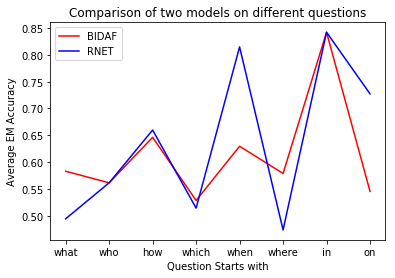

In [14]:
main_ques = ['what','who','how','which','when','where','in','on']
import numpy as np
X = np.arange(8)
import matplotlib.pyplot as plt
% matplotlib inline

fig=plt.figure() #Creates a new figure
ax1=fig.add_subplot(111) #Plot with: 1 row, 1 column, first subplot.

line1 = ax1.plot(main_ques, bidaf_list, '-r', label='BIDAF')
line2 = ax1.plot(main_ques, rnet_list, '-b', label='RNET')
# plt.axis('equal')

plt.legend()
# plt.figsize(10,10)

# plt.bar(main_ques, bidaf_list, 'red', main_ques, rnet_list, 'blue')
plt.ylabel('Average EM Accuracy')
# # plt.plot(main_ques,rnet_list, color='blue')
# # plt.axis(main_ques)
plt.xlabel('Question Starts with')
plt.title('Comparison of two models on different questions')
plt.savefig('plots/question_type.png')
plt.show()

### By Answer Length

In [16]:
def answer_len_analysis(json_file):

    predictions = json.load(open(json_file))
    output_dict = json.dumps(evaluate(dataset, predictions))

    dict_ques = json.loads(output_dict)
    
    ans_len_dist = {}
    for i in range(len(dict_ques)):
        ques = dict_ques.keys()[i]
        ans_len = dict_ques[ques][1]
    #     print(fw)
        if ans_len_dist.has_key(ans_len):
            ans_len_dist[ans_len] +=1
        else:
            ans_len_dist[ans_len] = 1
    
    len_response_dist = {}
    for i in range(len(dict_ques)):
        ques = dict_ques.keys()[i]
        ans_len = dict_ques[ques][1]
        ans = dict_ques[ques][0]
    #     print(fw, ans)
        if len_response_dist.has_key(ans_len):
            len_response_dist[ans_len] += ans
        else:
            len_response_dist[ans_len] = ans
            
            
    d4 = dict((k, float(len_response_dist[k]) / ans_len_dist[k]) for k in ans_len_dist)
    list1 = []
    main_ques = [1,2,3,4,5]
    for ques in main_ques:
        print("Question and dist are: ", ques, d4[ques], ans_len_dist[ques])
        list1.append(d4[ques])
    return list1

In [17]:
bidaf_list = answer_len_analysis('predictions_bidaf_prob.json')

Exact Match: 58.3950617284
F1:  65.9768945791
Question and dist are:  1 0.617940199336 301
Question and dist are:  2 0.648275862069 290
Question and dist are:  3 0.503496503497 143
Question and dist are:  4 0.379310344828 29
Question and dist are:  5 0.5 12


In [18]:
rnet_list = answer_len_analysis('predictions_rnet_prob.json')

Exact Match: 56.2962962963
F1:  64.6540487188
Question and dist are:  1 0.60625 320
Question and dist are:  2 0.654275092937 269
Question and dist are:  3 0.473282442748 131
Question and dist are:  4 0.41935483871 31
Question and dist are:  5 0.2 10


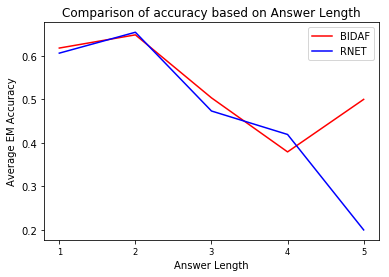

In [19]:
main_ques = [1,2,3,4,5]
import numpy as np
X = np.arange(8)
import matplotlib.pyplot as plt
% matplotlib inline

fig=plt.figure() #Creates a new figure
ax1=fig.add_subplot(111) #Plot with: 1 row, 1 column, first subplot.

line1 = ax1.plot(main_ques, bidaf_list, '-r', label='BIDAF')
line2 = ax1.plot(main_ques, rnet_list, '-b', label='RNET')
# plt.axis('equal')
plt.xticks(range(1,len(main_ques)+1), main_ques, size='small')

plt.legend()
# plt.figsize(10,10)

# plt.bar(main_ques, bidaf_list, 'red', main_ques, rnet_list, 'blue')
plt.ylabel('Average EM Accuracy')
# # plt.plot(main_ques,rnet_list, color='blue')
# # plt.axis(main_ques)
plt.xlabel('Answer Length')
plt.title('Comparison of accuracy based on Answer Length')
plt.savefig('plots/answer_length.png')
plt.show()
